# Running SPUD with Profile and and Visits as Domains

In [1]:
#Import necessary libraries

import sys
import os
import importlib

# Make it so you can get modules from the parent directory
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

import test_manifold_algorithms as tma
from MASH import MASH
import SPUD
importlib.reload(SPUD) #makes sure that you're always using the updated code
from SPUD import SPUD
from temporal_progression_comparisons import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


This is not running as __main__


In [2]:
LABEL_VARIABLE = "DX_bl"
SAMPLE_SIZE = 200

profile_raw = pd.read_excel(r"..\..\CSV Files\Profile Variables 2024-07-31.xlsx", index_col="RID")
visits_raw = pd.read_excel(r"..\..\CSV Files\Visit Variables 2024-08-01.xlsx", index_col = [0]) #index needs to be defined that way for reasons

#drop empty rows and fill in NaNs
profile_raw.dropna(how="all", inplace=True)
#profile_raw = profile_raw.fillna(-4)
visits_raw.dropna(how="all", inplace=True)
#visits_raw = visits_raw.fillna(-4)

#remap and delete a few variables, might make part of the merge later to be more steamlined on when to map and delete stuff
profile_raw['DX_bl'] = profile_raw['DX_bl'].map({'CN': 0, 'SMC': 1, 'EMCI': 2, 'LMCI': 3, 'AD': 4, 'NaN': -4, -4: -4})
profile_raw['PTMARRY'] = profile_raw['PTMARRY'].map({'Married': 1, 'Widowed': 2, 'Divorced': 3, 'Never married': 4, 'Unknown': -4, 'NaN': -4, -4: -4})

profile = profile_raw.drop(columns = [LABEL_VARIABLE, "PTRACCAT"])
visits = visits_raw.drop(columns = [])

label_column = profile_raw[LABEL_VARIABLE].fillna(-4)

In [3]:
#take the first SAMPLE_SIZE of people for domain_a
domain_a = np.array(profile)[:SAMPLE_SIZE].astype(float)

#get the unique rids in the sample and their corresponding visits for domain_b
sample_rids = list(profile.index.values)[:SAMPLE_SIZE]
visits_sample = visits[visits.index.isin(sample_rids)] #must be done this way because some of the sample_rids don't have any visits
domain_b = np.array(visits_sample)

In [4]:
#build the anchors list from the indecies of the corresponding RID labels
profile_anchors = list(profile.index.values)[:len(domain_a)]
visits_anchors = list(visits.index.values)[:len(domain_b)]

#make an anchor for every visit with its corresponding profile
anchors = []
for index, item in enumerate(visits_anchors):
    corresponding_profile_position = profile_anchors.index(item)
    new_anchor = [corresponding_profile_position, index]
    anchors.append(new_anchor)

#build the labels list
domain_a_labels = label_column[profile_anchors]
domain_b_labels = label_column[visits_anchors]
labels = pd.concat([domain_a_labels, domain_b_labels])


"""
#a more generic anchor generator, maybe to use later
anchors = []
for i, rid1 in enumerate(profile_anchors):
    # Compare it with each item in list2
    for j, rid2 in enumerate(visits_anchors):
        # If they match, store the indices as a pair
        if rid1 == rid2:
            anchors.append([i, j])
"""


'\n#a more generic anchor generator, maybe to use later\nanchors = []\nfor i, rid1 in enumerate(profile_anchors):\n    # Compare it with each item in list2\n    for j, rid2 in enumerate(visits_anchors):\n        # If they match, store the indices as a pair\n        if rid1 == rid2:\n            anchors.append([i, j])\n'

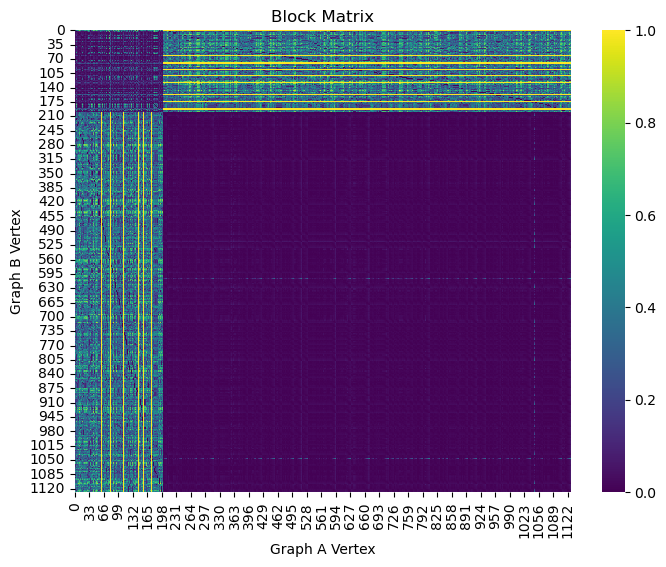

c:\Users\jcory\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Cross Embedding: 0.41473089343379976
Can't compute FOSCTTM with different domain shapes.


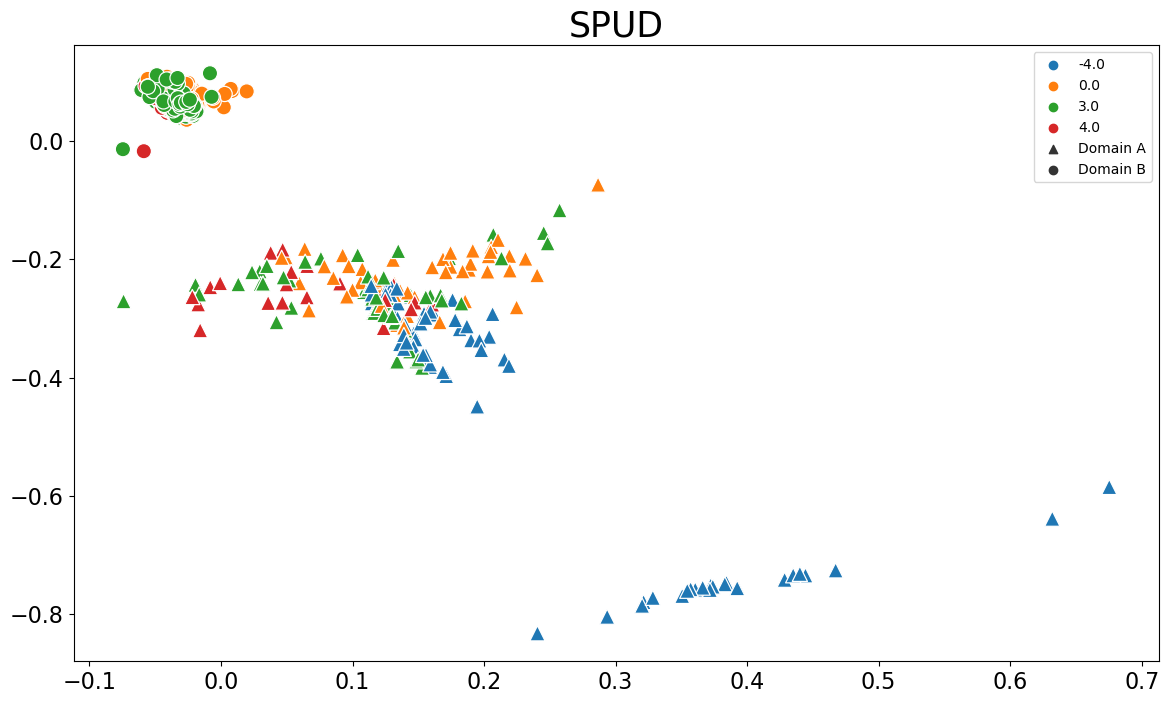

In [5]:
#Create the merged values --> This will take up the rest of your day
pv_spud = SPUD(n_pca = 10)
pv_spud.fit(domain_a, domain_b, known_anchors = anchors)
pv_spud.plot_heat_map()
#pv_spud.plot_graphs()
pv_spud.plot_emb(labels = labels, show_anchors = False, show_lines = False, n_comp = 2)